In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from scipy.optimize import minimize
import os   
import random

In [2]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:


# Load the CSV data
csv_path = '/home/guoguo/projects/QML/data/origin/parametric_modulation_data.csv'
data = pd.read_csv(csv_path)


# # Prepare the input and output data
y = data[['X1', 'Y1', 'X2', 'Y2',]].values
X = data[['B_freq', 'B_ampl', 'x_offset', 'y_offset', 'z_offset']].values

# # Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train_tensor = torch.tensor(y, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



In [6]:
# Define the neural network model
class GradientPredictor(nn.Module):
     
    def __init__(self, input_size, output_size):
        super(GradientPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 4),
            nn.Sigmoid(),
            # nn.Dropout(0.2),
            nn.Linear(4, 4),
            nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # # nn.Dropout(0.2),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            nn.Linear(4, 4),
            nn.Tanh(),
            nn.Linear(4, output_size)
        )

    def forward(self, x):
        return self.fc(x)


In [7]:
best_model_path = 'best_model.pth'
training_losses_path = 'training_losses.npy'
input_size = X.shape[1]
output_size = y.shape[1]
model = GradientPredictor(input_size, output_size)


In [6]:
# Update the optimizer initialization with adjusted settings
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-6)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Create DataLoader for mini-batch training
batch_size = 32
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Training the model with mini-batch training using MSE loss
epochs = 100
training_losses = []
patience = 20
best_train_loss = float('inf')

stopping_counter = 0

for epoch in range(epochs):
    model.train()
    epoch_training_loss = 0.0
    for batch_X, batch_y in dataloader_train:
        optimizer.zero_grad()  # Clear the gradients
        
        # Forward pass
        predictions = model(batch_X)
        loss = nn.MSELoss()(predictions, batch_y)  # Use MSE for training
        epoch_training_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
    
    # Average training loss for the epoch
    epoch_training_loss /= len(dataloader_train)
    training_losses.append(epoch_training_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Training Loss: {epoch_training_loss:.8f}")
    
    # Step the scheduler
    scheduler.step(epoch_training_loss)
    
    # Early stopping and model checkpointing based on training loss
    if epoch_training_loss < best_train_loss:
        best_train_loss = epoch_training_loss
        stopping_counter = 0
        # Save the model
        torch.save(model.state_dict(), best_model_path)
    else:
        stopping_counter += 1
    
    if stopping_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Save the training losses
np.save(training_losses_path, training_losses)

# Load the best model
model.load_state_dict(torch.load(best_model_path))
    
    # Evaluation



/home/guoguo/anaconda3/envs/VAM/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [0/100], Training Loss: 0.29332566
Epoch [10/100], Training Loss: 0.00606505
Epoch [20/100], Training Loss: 0.00374546
Epoch [30/100], Training Loss: 0.00199621
Epoch [40/100], Training Loss: 0.00191084
Epoch [50/100], Training Loss: 0.00154197
Epoch [60/100], Training Loss: 0.00155052
Epoch [70/100], Training Loss: 0.00061624
Epoch [80/100], Training Loss: 0.00033096
Epoch [90/100], Training Loss: 0.00023065


/tmp/ipykernel_2611094/197711821.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

Training Loss: 0.00022912


/tmp/ipykernel_2643444/645448477.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


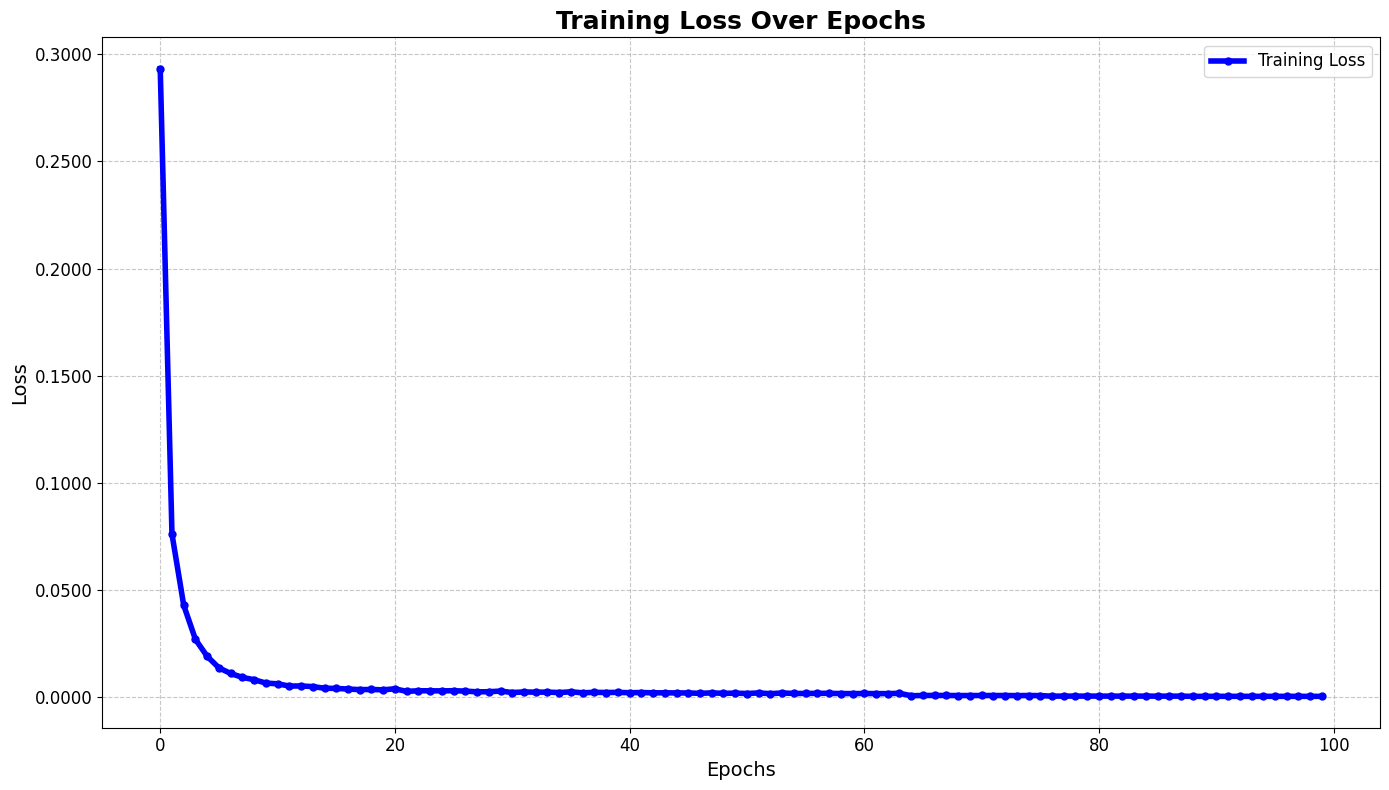

In [10]:
from matplotlib.ticker import FormatStrFormatter
# Load the best model
# best_model_path = 'best_model1.pth'
model.load_state_dict(torch.load(best_model_path))

model.eval()
criterion = nn.MSELoss()
with torch.no_grad():
    y_train_pred = model(X_train_tensor)
    loss = criterion(y_train_pred, y_train_tensor).item()

print(f"Training Loss: {loss:.8f}")
training_losses = np.load(training_losses_path)
# Plot the predicted vs true values for the training set
y_train_pred = y_train_pred.numpy()
y_train_true = y_train_tensor.numpy()


# Plotting the training and evaluation losses
plt.figure(figsize=(14, 8))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.plot(training_losses, label='Training Loss', color='b', linewidth=4, marker='o', markersize=5, linestyle='-')
# plt.yscale('log')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss Over Epochs', fontsize=18, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



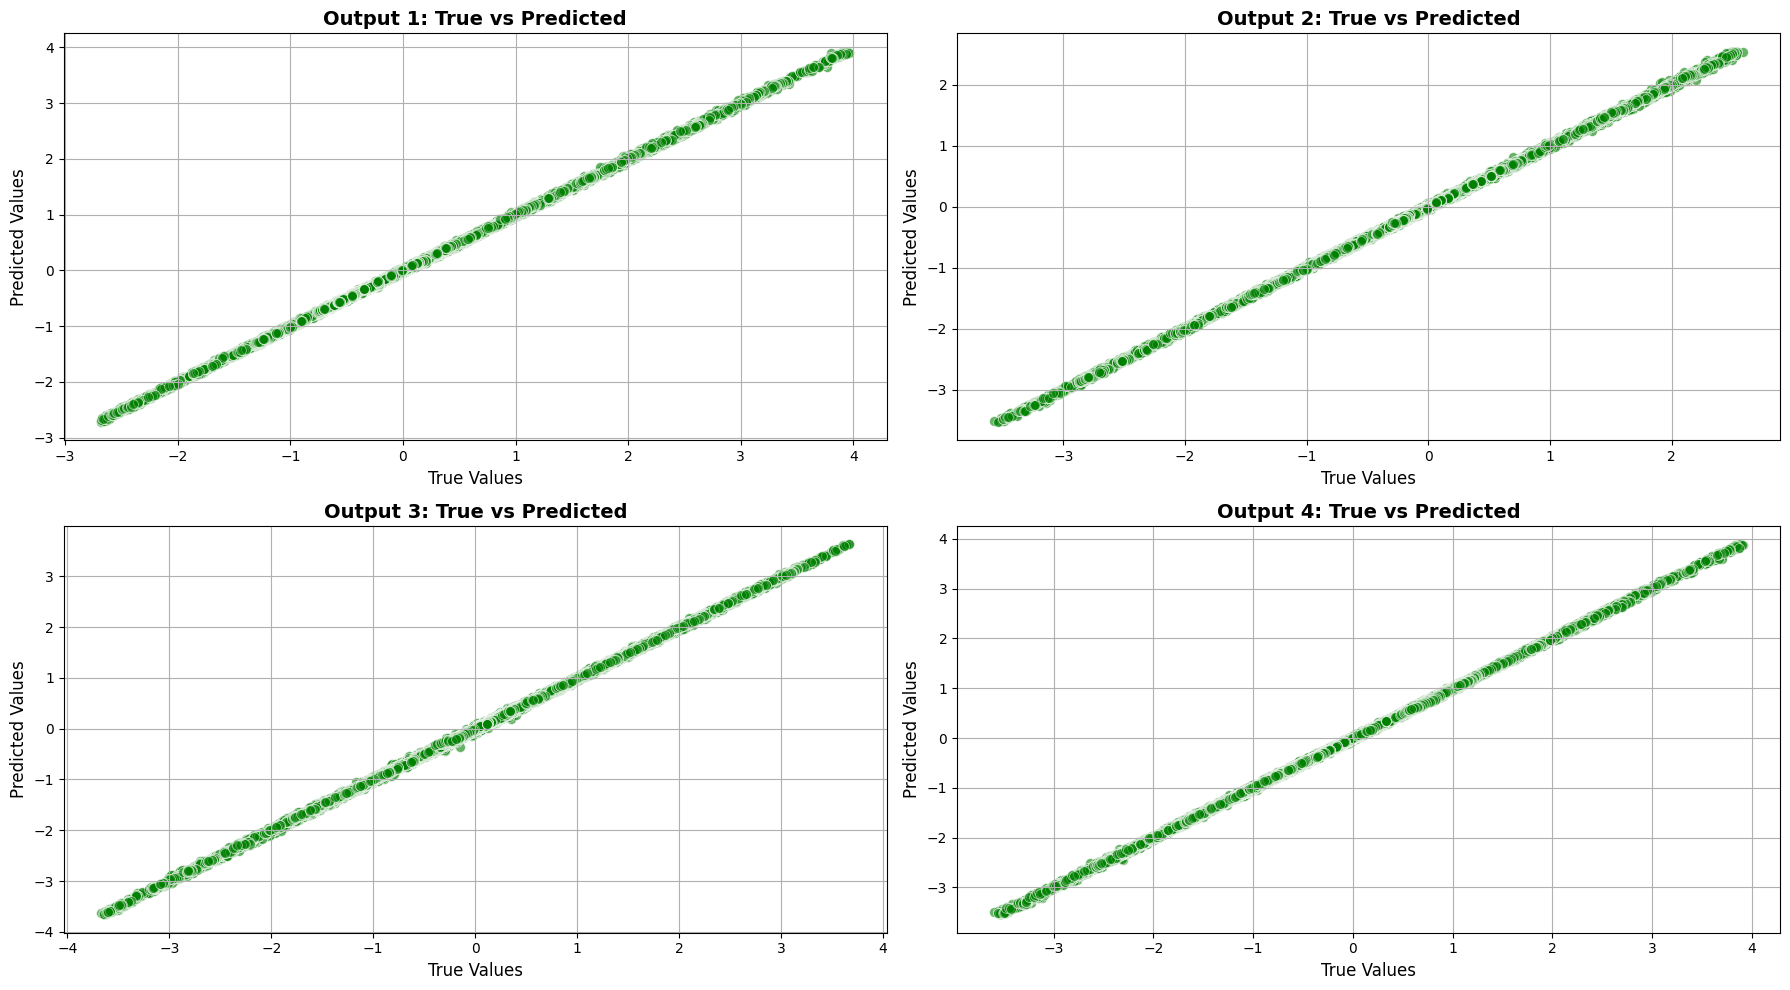

In [11]:
# # Plotting predicted vs true values for the test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_train_tensor).numpy()
    y_test_true = y_train_tensor.numpy()

plt.figure(figsize=(18, 10))
for i in range(output_size):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=y_test_true[:, i], y=y_test_pred[:, i], alpha=0.6, s=50, color='g', edgecolor='w')
    plt.xlabel('True Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.title(f'Output {i + 1}: True vs Predicted', fontsize=14, fontweight='bold')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Post-training optimization to achieve desired objective

from torch.autograd.functional import jacobian

# Define a function that takes a tensor input and returns a tensor output
def model_function(input_tensor):
    # Assume input_tensor is already a torch.Tensor and h h h h h             as requires_grad=True
    return model(input_tensor)

# Ensure X_train_tensor is a torch tensor and has requires_grad=True
X_train_tensor = X_train_tensor.clone().detach().requires_grad_(True).float()

# Compute the Jacobian matrix using torch.autograd.functional.jacobian
jacobian_matrix = jacobian(model_function, X_train_tensor)

print(jacobian_matrix)


KeyboardInterrupt: 

In [ ]:
save_path = 'jacobian_matrix.npy'
np.save(save_path, jacobian_matrix)

In [ ]:
# cost function
def custom_objective_function(input_values):

    input_tensor = torch.tensor(input_values, dtype=torch.float32).unsqueeze(0)

    gradient = torch.autograd.grad(model(input_tensor), 
                                   input_tensor, 
                                   grad_outputs=torch.ones_like(input_tensor), 
                                   create_graph=True)[0]

    with torch.grad():
        predicted_output = model(input_tensor).numpy().flatten()
  
   
    # B_freq,B_ampl,x_offset,y_offset,z_offset = predicted_output
    X1,Y1,X2,Y2 = predicted_output
    
    objective = 0
    
    return objective,gradient



# Initial guess (e.g., mean of the training data)
initial_guess = X.mean(axis=0)


# Use Scipy minimize to find the optimal input values
result = minimize(custom_objective_function, initial_guess, method='L-BFGS-B',jac='3-point')

# Optimal input values found
optimal_input = result.x
optimal_input = scaler_X.inverse_transform(optimal_input.reshape(1, -1)).flatten()
print("Optimal Input Values:", optimal_input)

# Predicted output for the optimal input
optimal_input_tensor = torch.tensor(optimal_input, dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    optimal_output = model(optimal_input_tensor).numpy().flatten()
optimal_output = scaler_y.inverse_transform(optimal_output.reshape(1, -1)).flatten()
ob = custom_objective_function(optimal_input)
print("Objective Value:", ob)

print("Predicted Output for Optimal Input:", optimal_output)
# plot the predicted output for optimal input
plt.figure(figsize=(18, 10))
plt.bar(range(6), optimal_output, color='b', alpha=0.6, edgecolor='w')
plt.xlabel('Output Index', fontsize=12)
plt.ylabel('Predicted Value', fontsize=12)
plt.title('Predicted Output for Optimal Input', fontsize=14, fontweight='bold')
plt.grid(True)
plt.xticks(range(6), ['g1_x', 'g1_y', 'g1_z', 'g2_x', 'g2_y', 'g2_z'])
plt.tight_layout()

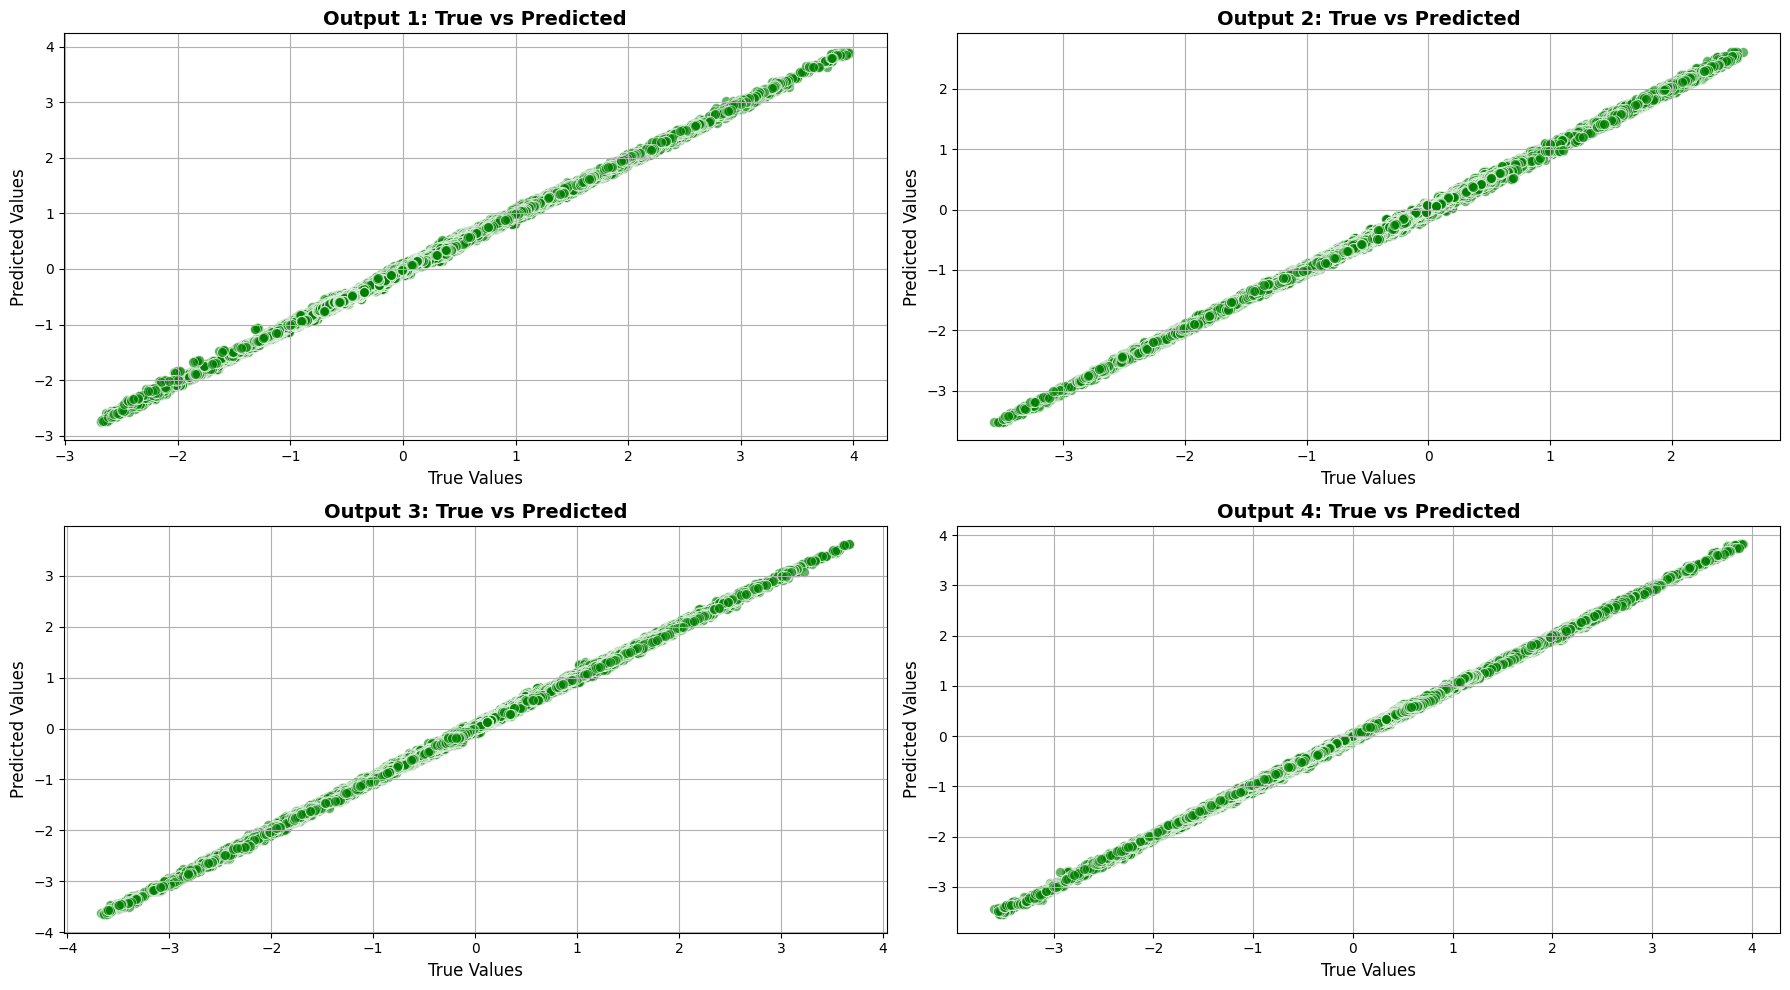

In [ ]:

# model.load_state_dict(torch.load(best_model_path))

# Define the desired output
desired_output = np.array([1, 0, 0, 0, 1, 0])

# Define the objective function to minimize the difference between the model's output and the desired output
def objective_function(input_values):
    input_tensor = torch.tensor(input_values, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        predicted_output = model(input_tensor).numpy().flatten()
    
    # Calculate the difference between the predicted output and the desired output
    difference = predicted_output - desired_output
    objective = np.sum(difference ** 2)  # Sum of squared differences
    return objective

# Define a set of initial guesses (e.g., mean of the training data, random samples, etc.)
initial_guesses = [
    X.mean(axis=0),
    # np.random.uniform(X.min(axis=0), X.max(axis=0)),
]

# Store the results for each initial guess
results = []

for initial_guess in initial_guesses:
    # Use Scipy minimize to find the optimal input values
    result = minimize(objective_function, initial_guess, method='L-BFGS-B')
    
    # Optimal input values found
    optimal_input = result.x
    optimal_input = scaler_X.inverse_transform(optimal_input.reshape(1, -1)).flatten()
    print("Optimal Input Values:", optimal_input)
    
    # Predicted output for the optimal input
    optimal_input_tensor = torch.tensor(optimal_input, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        optimal_output = model(optimal_input_tensor).numpy().flatten()
    optimal_output = scaler_y.inverse_transform(optimal_output.reshape(1, -1)).flatten()
    objective_value = objective_function(optimal_input)
    print("Objective Value:", objective_value)
    
    print("Predicted Output for Optimal Input:", optimal_output)
    
    # Store the result
    results.append({
        'initial_guess': initial_guess,
        'optimal_input': optimal_input,
        'optimal_output': optimal_output,
        'objective_value': objective_value
    })


Optimal Input Values: [ 3.03300000e+03  2.39845052e+00 -8.73964497e-01  9.90996535e-01
  5.98816568e-02]
Objective Value: 10.213625886948234
Predicted Output for Optimal Input: [-2.1931041e-06 -3.9914234e-05 -2.9231387e-05 -4.5662014e-06
 -6.3357361e-06  8.1498847e-06]


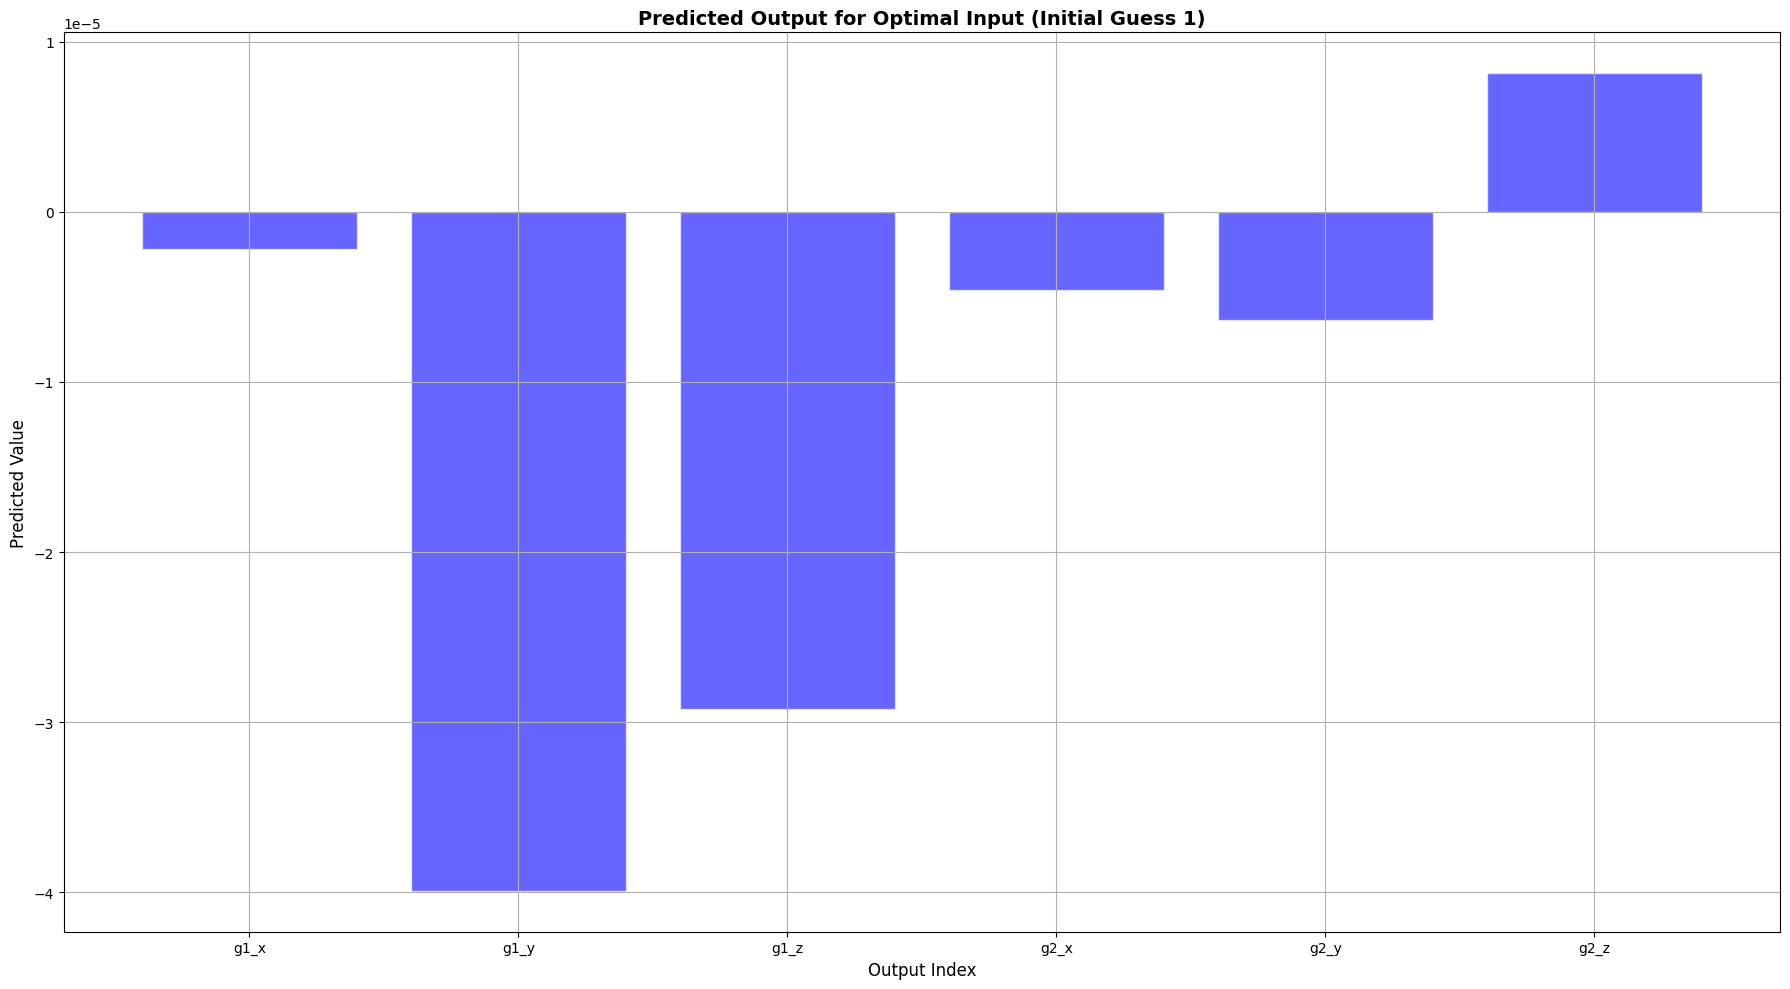

In [ ]:
# Plot the predicted output for the optimal input for each initial guess
for i, result in enumerate(results):
    plt.figure(figsize=(18, 10))
    plt.bar(range(6), result['optimal_output'], color='b', alpha=0.6, edgecolor='w')
    plt.xlabel('Output Index', fontsize=12)
    plt.ylabel('Predicted Value', fontsize=12)
    plt.title(f'Predicted Output for Optimal Input (Initial Guess {i+1})', fontsize=14, fontweight='bold')
    plt.grid(True)
    plt.xticks(range(6), ['g1_x', 'g1_y', 'g1_z', 'g2_x', 'g2_y', 'g2_z'])
    plt.tight_layout()
    plt.show()

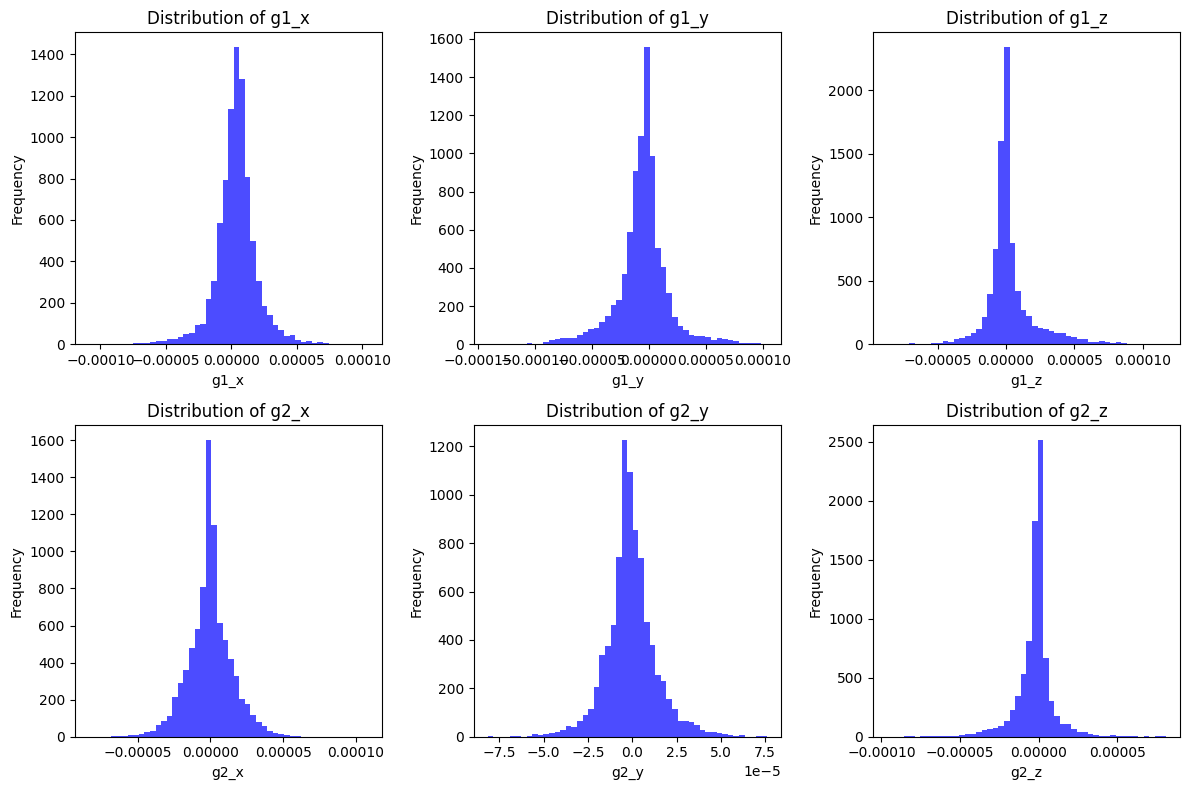

In [ ]:
plt.figure(figsize=(12, 8))

for i, label in enumerate(['g1_x', 'g1_y', 'g1_z', 'g2_x', 'g2_y', 'g2_z']):
    plt.subplot(2, 3, i + 1)
    plt.hist(data[label], bins=50, color='blue', alpha=0.7)
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {label}')

plt.tight_layout()
plt.show()